In [3]:
#import libraries
library(tidyverse)
library(runjags)
library(coda)
library(dplyr)
library(bayesplot)
library(ggplot2)
#library(rstanarm) 

Task: Compute with JAGS or stan the efficacy of each vaccine. Infer the the 95% credibility interval.

In [4]:
#collect all data from different vaccines

,demographics,comirnaty,placebo
1,male,9318.0,9225.0
2,female,8924.0,9154.0
3,mean age,50.6,50.4
4,12-15,46.0,42.0
5,16-64,14216.0,14299.0
6,65-74,3176.0,3226.0
7,over 75,804.0,812.0
Total,NA,18242.0,18379.0


,COVID.19.first.occurance,comirnaty,placebo
1,"After dose 1, before dose 2",39,82
2,Dose 2 day to 7 days after,2,21
3,over 7 days after dose 2,9,172
Total,NA,50,275


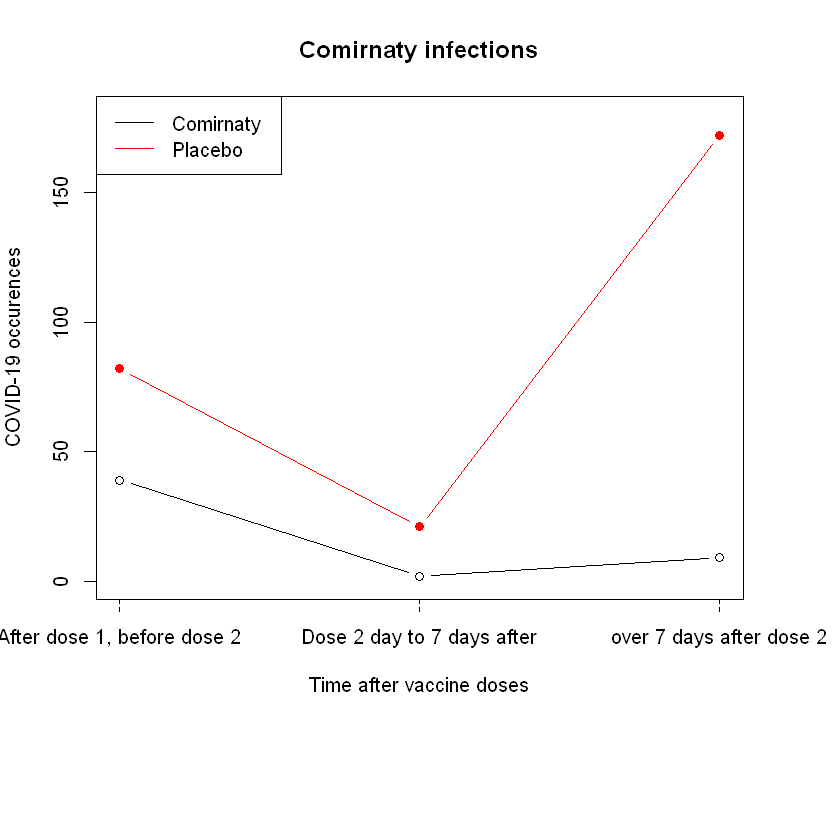

In [5]:
#Comirnaty data
participants_comirnaty <- data.frame ('demographics'=c("male", "female", "mean age", "12-15", "16-64", "65-74", "over 75"), 
                            'comirnaty'=c(9318, 8924, 50.6, 46, 14216, 3176, 804), 
                            'placebo'=c(9225, 9154, 50.4, 42, 14299, 3226, 812))
participants_comirnaty["Total", c(2,3)] <- colSums(participants_comirnaty[1:2,2:3])
participants_comirnaty
#number of positive cases
comirnaty_infections <- data.frame ('COVID-19 first occurance' = c("After dose 1, before dose 2", "Dose 2 day to 7 days after", "over 7 days after dose 2"),
                                 'comirnaty' = c(39, 2, 9),
                                 'placebo' = c(82, 21, 172))
comirnaty_infections["Total", c(2,3)] <- colSums(comirnaty_infections[2:3])
comirnaty_infections
#graph of infections over time
par(mar = c(10,4,4,4))
plot(comirnaty_infections$comirnaty[1:3],
         ylab = ("COVID-19 occurences"),
         xaxt = 'n',
         xlab = 'Time after vaccine doses',
         ylim = c(0, 180),
         type = 'b',
         main = 'Comirnaty infections')
axis(1, at = 1:3,
         labels = (comirnaty_infections$COVID.19.first.occurance[1:3]), 
         lty = 2)
     
points(comirnaty_infections[c(1,3)], 
         pch = 19, type = 'b', 
         col = 'red')

#add legend
legend("topleft", legend=c("Comirnaty", "Placebo"),
         col=c("black", "red"), lty = 1, cex=1.0)

In [6]:
#efficacy for comirnaty 
tot_vaccinated <- 18242
tot_placebo <- 18379

patient <- c(rep("Vaccine", tot_vaccinated),
             rep("Placebo", tot_placebo))

#number patients positive in total over trial
pos_vaccinated <- 50
pos_placebo <- 275
tested <- c(rep("Positive", pos_vaccinated),
           rep("Negative", tot_vaccinated - pos_vaccinated),
           rep("Positive", pos_placebo),
           rep("Negative", tot_placebo - pos_placebo))

comirnaty.tb <- tibble(tested = tested, patient = patient)
#show table
table(comirnaty.tb[[2]], comirnaty.tb[[1]])

         
          Negative Positive
  Placebo    18104      275
  Vaccine    18192       50

In [7]:
#organise data to use in JAGS
dataListComirnaty = list(
    tested = ifelse(comirnaty.tb$tested == "Negative", 0, 1),
    patient = as.integer(factor(comirnaty.tb$patient)), 

    Ntot = nrow(comirnaty.tb),
    Nclass = nlevels(factor(comirnaty.tb$patient))
)

In [8]:
#Moderna data
participants_moderna <- data.frame ('demographics'=c("male", "female", "mean age", "18-65", "over 65"), 
                            'moderna'=c(7366, 6768, 51.6, 10551, 3585), 
                            'placebo'=c(7462, 6611, 51.6, 10521, 3552))
participants_moderna["Total", c(2,3)] <- colSums(participants_moderna[1:2,2:3])
#number of incidences of COVID-19 from 14 days after second dose until end of observation period
positive_cases <- data.frame ('demographics'=c('+ case 18-65', '+ case over 65'), 
                              'moderna'=c(7, 4), 
                              'placebo' = c(156, 29))
participants_moderna <- merge(participants_moderna, positive_cases, all=TRUE)
participants_moderna


demographics,moderna,placebo
18-65,10551.0,10521.0
female,6768.0,6611.0
male,7366.0,7462.0
mean age,51.6,51.6
over 65,3585.0,3552.0
+ case 18-65,7.0,156.0
+ case over 65,4.0,29.0
NA,14134.0,14073.0


In [9]:
#efficacy for moderna 
tot_vaccinated <- 14143
tot_placebo <- 14073

patient <- c(rep("Vaccine", tot_vaccinated),
             rep("Placebo", tot_placebo))

#number patients positive in total over trial
pos_vaccinated <- 11
pos_placebo <- 185
tested <- c(rep("Positive", pos_vaccinated),
           rep("Negative", tot_vaccinated - pos_vaccinated),
           rep("Positive", pos_placebo),
           rep("Negative", tot_placebo - pos_placebo))

moderna.tb <- tibble(tested = tested, patient = patient)
#show table
table(moderna.tb[[2]], moderna.tb[[1]])

         
          Negative Positive
  Placebo    13888      185
  Vaccine    14132       11

In [10]:
#organise data to use in JAGS
dataListModerna = list(
    tested = ifelse(moderna.tb$tested == "Negative", 0, 1),
    patient = as.integer(factor(moderna.tb$patient)), 

    Ntot = nrow(moderna.tb),
    Nclass = nlevels(factor(moderna.tb$patient))
)

In [11]:
#AstraZeneca data
participants_astra <- data.frame ('Demographics'=c("male", "female", "mean age", "18-65", "over 65"), 
                            'AstraZeneca'=c(2360, 2898, 44.37, 4572, 686), 
                            'Placebo'=c(2322, 2888, 44.46, 4545, 665))
participants_astra["Total", c(2,3)] <- colSums(participants_astra[1:2,2:3])
participants_astra
#number of positive cases
positive_cases_astra <- data.frame ('AstraZeneca' = 64, 'Placebo' = 154)
positive_cases_astra

,Demographics,AstraZeneca,Placebo
1,male,2360.00,2322.00
2,female,2898.00,2888.00
3,mean age,44.37,44.46
4,18-65,4572.00,4545.00
5,over 65,686.00,665.00
Total,NA,5258.00,5210.00


AstraZeneca,Placebo
64,154


In [12]:
#efficacy for astra 
tot_vaccinated <- 5258
tot_placebo <- 5210

patient <- c(rep("Vaccine", tot_vaccinated),
             rep("Placebo", tot_placebo))

#number patients positive in total over trial
pos_vaccinated <- 64
pos_placebo <- 154
tested <- c(rep("Positive", pos_vaccinated),
           rep("Negative", tot_vaccinated - pos_vaccinated),
           rep("Positive", pos_placebo),
           rep("Negative", tot_placebo - pos_placebo))

astra.tb <- tibble(tested = tested, patient = patient)
#show table
table(astra.tb[[2]], astra.tb[[1]])

         
          Negative Positive
  Placebo     5056      154
  Vaccine     5194       64

In [13]:
#organise data to use in JAGS
dataListAstra = list(
    tested = ifelse(astra.tb$tested == "Negative", 0, 1),
    patient = as.integer(factor(astra.tb$patient)), 

    Ntot = nrow(astra.tb),
    Nclass = nlevels(factor(astra.tb$patient))
)

In [14]:
#efficacy for janssen 
tot_vaccinated <- 19630
tot_placebo <- 19691

patient <- c(rep("Vaccine", tot_vaccinated),
             rep("Placebo", tot_placebo))

#number patients positive in total over trial
pos_vaccinated <- 116
pos_placebo <- 348
tested <- c(rep("Positive", pos_vaccinated),
           rep("Negative", tot_vaccinated - pos_vaccinated),
           rep("Positive", pos_placebo),
           rep("Negative", tot_placebo - pos_placebo))

janssen.tb <- tibble(tested = tested, patient = patient)
#show table
table(janssen.tb[[2]], janssen.tb[[1]])

         
          Negative Positive
  Placebo    19343      348
  Vaccine    19514      116

In [15]:
#organise data to use in JAGS
dataListJanssen = list(
    tested = ifelse(janssen.tb$tested == "Negative", 0, 1),
    patient = as.integer(factor(janssen.tb$patient)), 

    Ntot = nrow(janssen.tb),
    Nclass = nlevels(factor(janssen.tb$patient))
)

In [16]:
#add all data into a list
all_data <- list(dataListComirnaty, dataListModerna, dataListAstra, dataListJanssen)
for (n in all_data) {
    print (summary(n))
    }

        Length Class  Mode   
tested  36621  -none- numeric
patient 36621  -none- numeric
Ntot        1  -none- numeric
Nclass      1  -none- numeric
        Length Class  Mode   
tested  28216  -none- numeric
patient 28216  -none- numeric
Ntot        1  -none- numeric
Nclass      1  -none- numeric
        Length Class  Mode   
tested  10468  -none- numeric
patient 10468  -none- numeric
Ntot        1  -none- numeric
Nclass      1  -none- numeric
        Length Class  Mode   
tested  39321  -none- numeric
patient 39321  -none- numeric
Ntot        1  -none- numeric
Nclass      1  -none- numeric


In [17]:
#define JAGS model
#use a beta prior
modelString <- "
  model {
    #likelihood
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
    #priors
    for ( k in 1:Nclass ) {
      theta[k] ~ dbeta(3 , 100)
    }
  }"

In [18]:
#run JAGS and save data into a list
my_chain <- list()
for (data in all_data) {
    chain <- run.jags(modelString, 
            method = "parallel",
            monitor = c("theta"),
            data = data,
            n.chains = 4)
    my_chain[[length(my_chain) + 1]] <- chain
}

Warning message:
"No initial values were provided - JAGS will use the same initial values for all chains"Warning message:
"You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values."

Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Mon Feb 07 12:55:24 2022
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 36621
   Unobserved stochastic nodes: 2
   Total graph size: 73248
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 10000
-------------------------------------------------| 10000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: the model did not requ

Warning message:
"No initial values were provided - JAGS will use the same initial values for all chains"Warning message:
"You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values."

Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Mon Feb 07 12:55:44 2022
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 28216
   Unobserved stochastic nodes: 2
   Total graph size: 56438
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 10000
-------------------------------------------------| 10000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: the model did not requ

Warning message:
"No initial values were provided - JAGS will use the same initial values for all chains"Warning message:
"You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values."

Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Mon Feb 07 12:56:01 2022
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10468
   Unobserved stochastic nodes: 2
   Total graph size: 20942
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 10000
-------------------------------------------------| 10000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

Warning message:
"No initial values were provided - JAGS will use the same initial values for all chains"Warning message:
"You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values."

Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Mon Feb 07 12:56:10 2022
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 39321
   Unobserved stochastic nodes: 2
   Total graph size: 78648
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 10000
-------------------------------------------------| 10000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


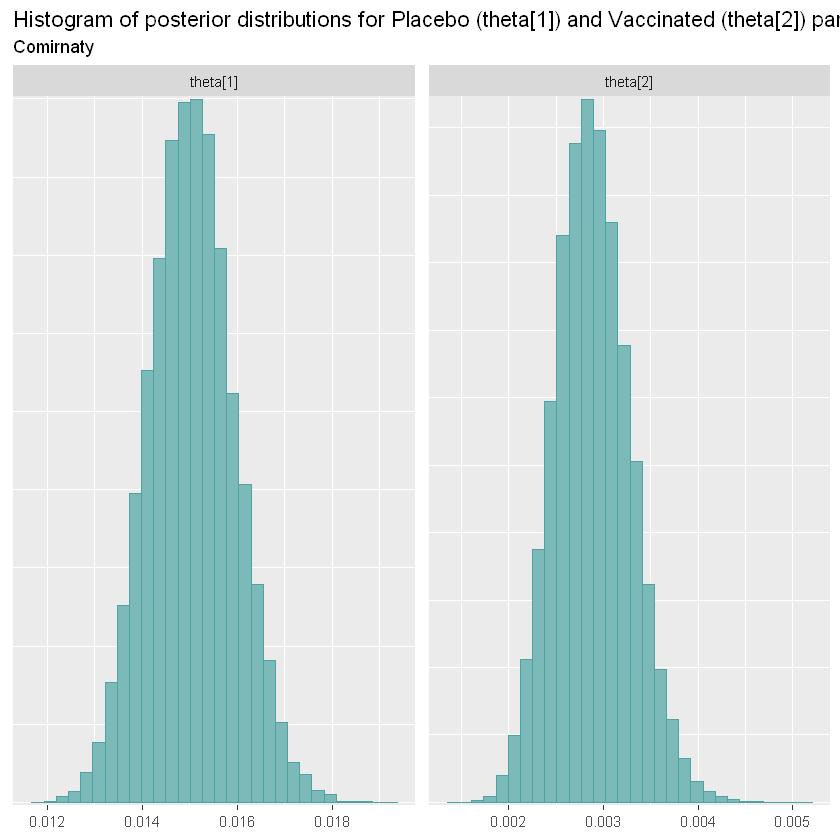

[1] "95% Cred. Int 0.0132979 - 0.0168021              95% Cred. Int 0.00212564 - 0.00367081"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


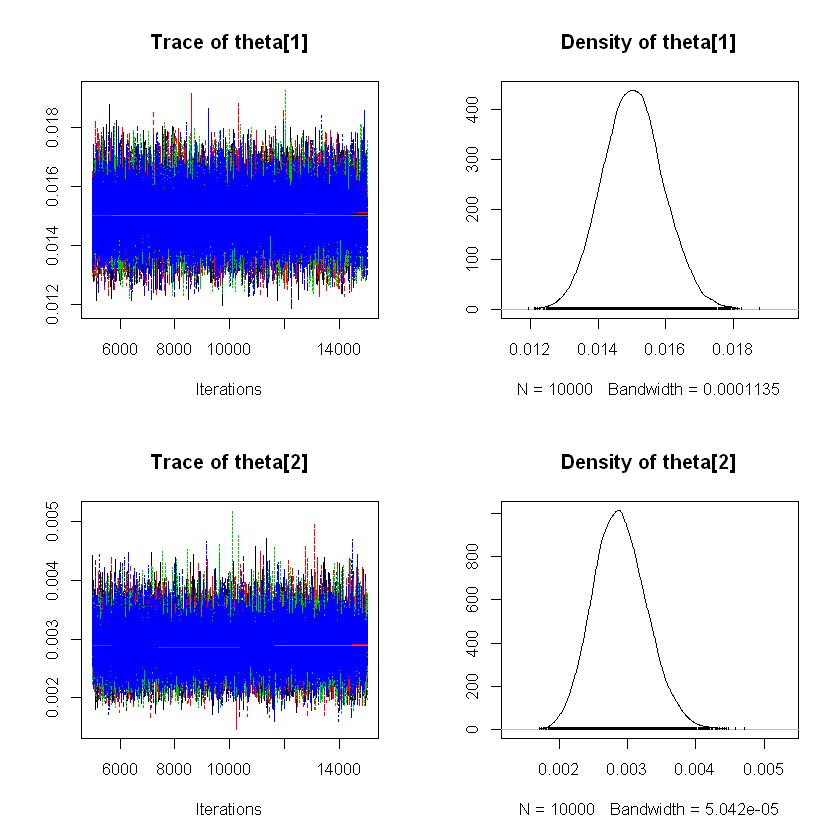

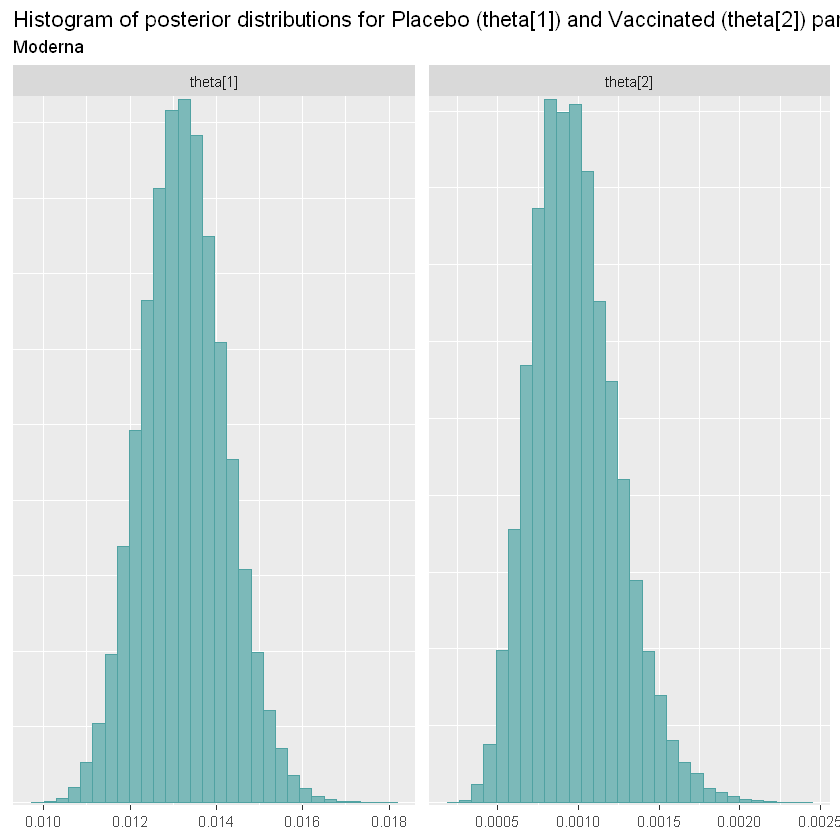

[1] "95% Cred. Int 0.0113853 - 0.0151367              95% Cred. Int 0.000506713 - 0.00151164"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


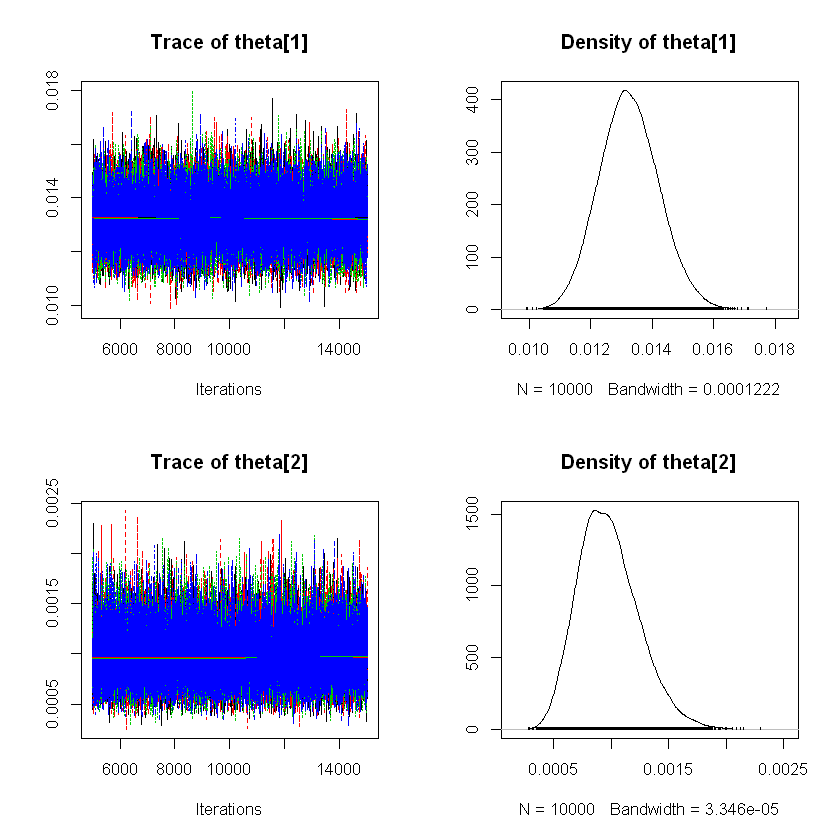

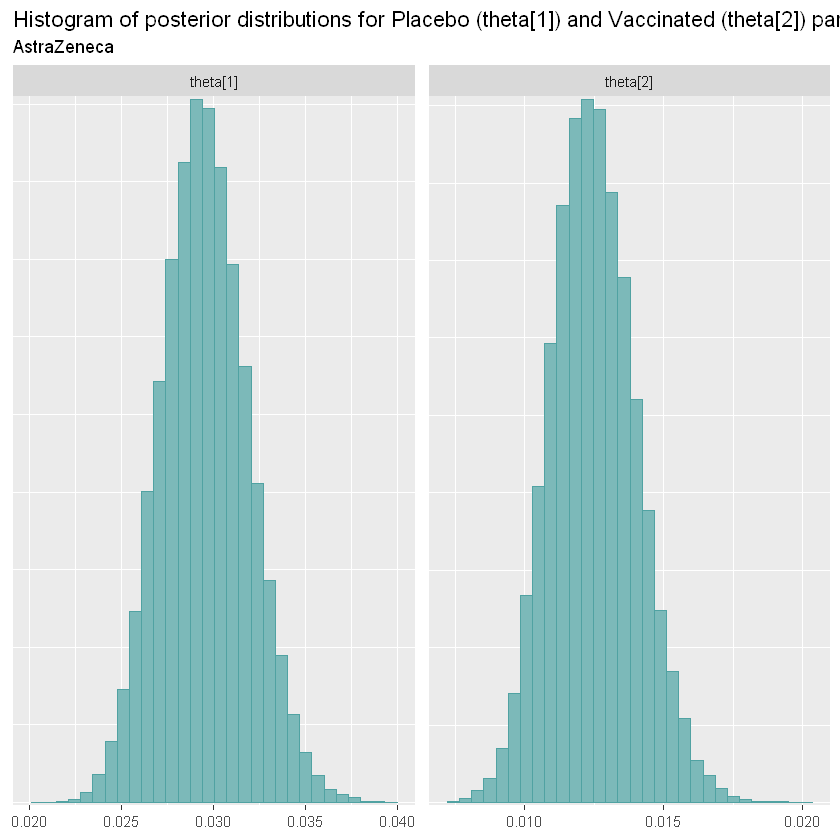

[1] "95% Cred. Int 0.0249474 - 0.0340529              95% Cred. Int 0.00953787 - 0.0154913"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


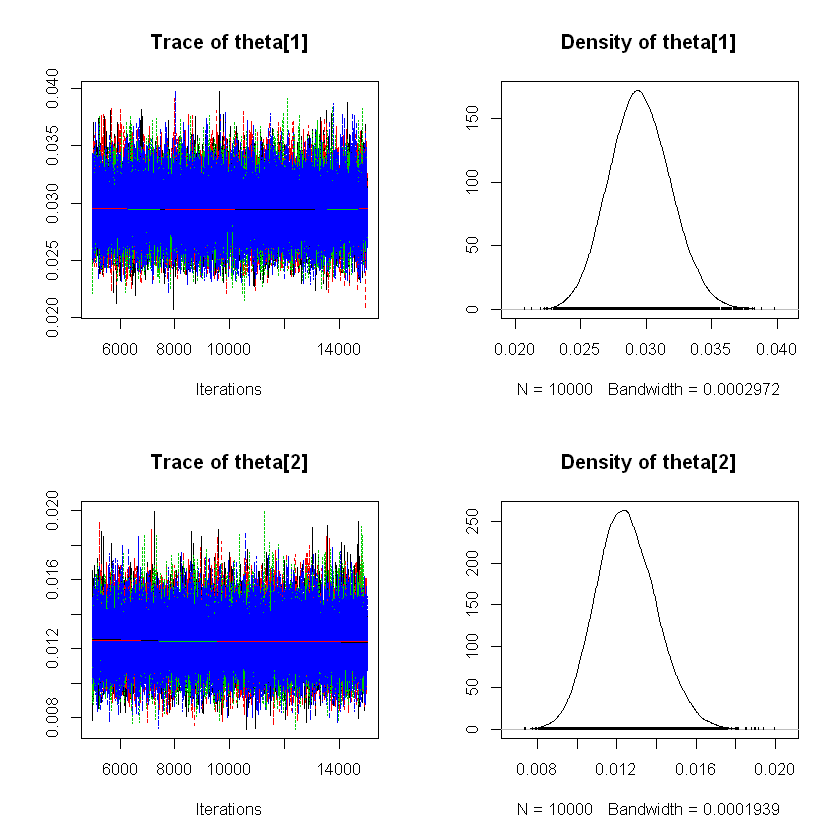

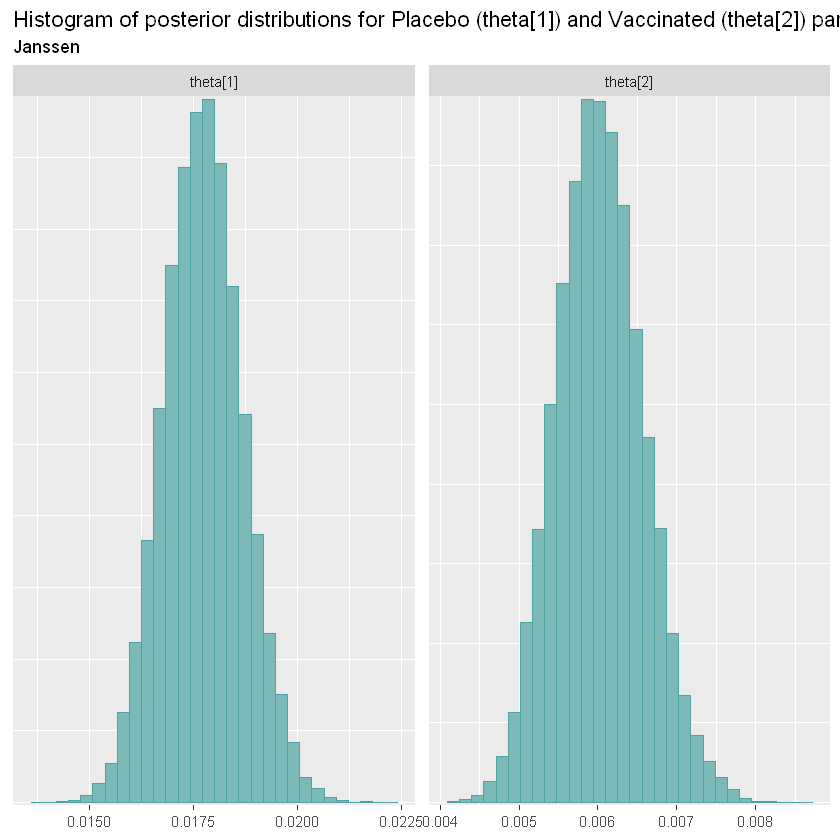

[1] "95% Cred. Int 0.0159297 - 0.019644              95% Cred. Int 0.00494958 - 0.00709572"


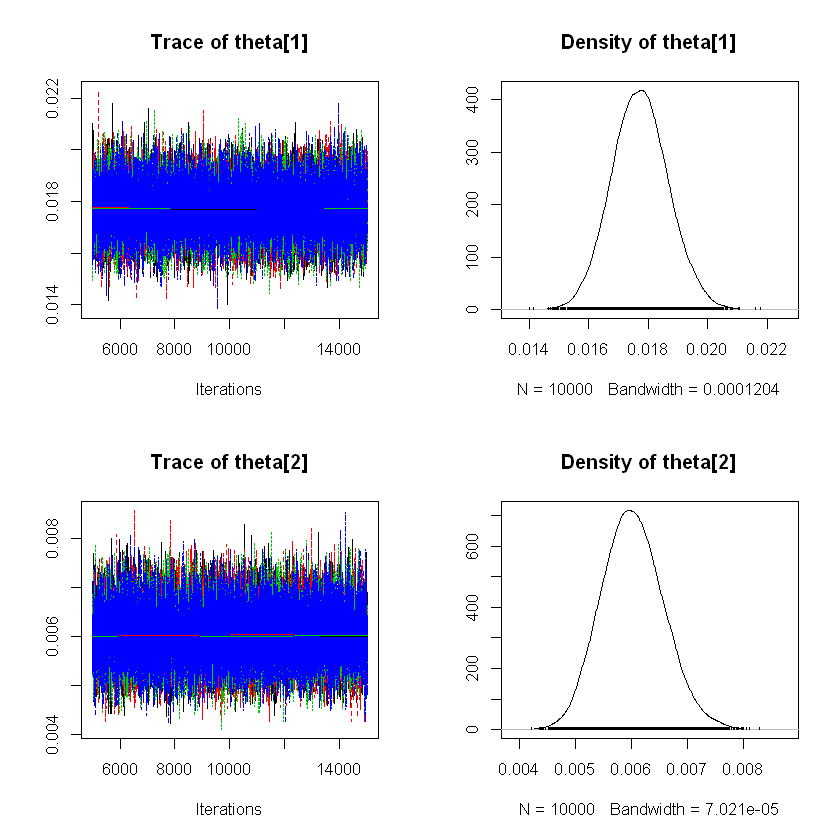

In [37]:
#plot trace and density using mcmc histogram plots
color_scheme_set("teal")
plot_names <- c("Comirnaty", "Moderna", "AstraZeneca", "Janssen")

my_plots <- list()

#par(mfrow = c(2, 2), mar = c(5, 5, 0.5, 5))
my_stats <- list()
for (i in 1:length(my_chain)) {
 
        stats <- summary(my_chain[[i]])
        my_stats[[length(my_stats) + 1]] <- stats
        coeff <- as.mcmc.list(my_chain[[i]], vars=c("theta[1]", "theta[2]"))
        plot <- mcmc_hist(coeff)
        print(plot + ggtitle("Histogram of posterior distributions for Placebo (theta[1]) and Vaccinated (theta[2]) participants",
                        subtitle = plot_names[i]))
        plot(coeff)
        print(paste("95% Cred. Int", my_stats[[i]][1,1], "-", my_stats[[i]][1,3], "            ", 
                   "95% Cred. Int", my_stats[[i]][2,1], "-", my_stats[[i]][2,3]))
        my_plots[[length(my_plots) + 1]] <- plot
}

In [20]:
#finding 95 confidence interval

intervals_95 <- list()

for (i in 1:4) {
    data <- my_stats[i]
    summary_stats <- do.call(rbind.data.frame, data)
    
    #modify tibble 
    summary_stats <- summary_stats %>% add_row(tibble_row())
    summary_stats[3,] <- ((summary_stats[1,]-summary_stats[2,])/summary_stats[1,])*100
    
    #print("Stats for vaccine efficacy of", 
    print(plot_names[i])
    print(summary_stats[3,1:3])
    print("-----")
    
    #save values into a list
    intervals_95[[length(intervals_95) + 1]] <- summary_stats[3,]

}

[1] "Comirnaty"
      Lower95   Median  Upper95
...3 84.01522 80.89119 78.15267
[1] "-----"
[1] "Moderna"
      Lower95   Median  Upper95
...3 95.54941 92.76058 90.01341
[1] "-----"
[1] "AstraZeneca"
      Lower95   Median  Upper95
...3 61.76808 57.81766 54.50813
[1] "-----"
[1] "Janssen"
      Lower95   Median  Upper95
...3 68.92861 66.05827 63.87844
[1] "-----"


In [19]:
#plot intevals on same axis to compare 

In [20]:
#my_stats
intervals_95 <- do.call(rbind.data.frame,intervals_95)
intervals_95_i <- intervals_95[1:5]
intervals_95_i

,Lower95,Median,Upper95,Mean,SD
...3,84.03367,80.91340,78.26593,80.80786,55.97043
...31,95.56614,92.75548,90.03051,92.59761,72.50864
...32,61.57191,57.88293,54.45884,57.74841,34.82339
...33,68.85514,66.05009,63.75047,65.98001,41.45781


In [21]:
intervals_95_i[1,4]

[1] 80.80786

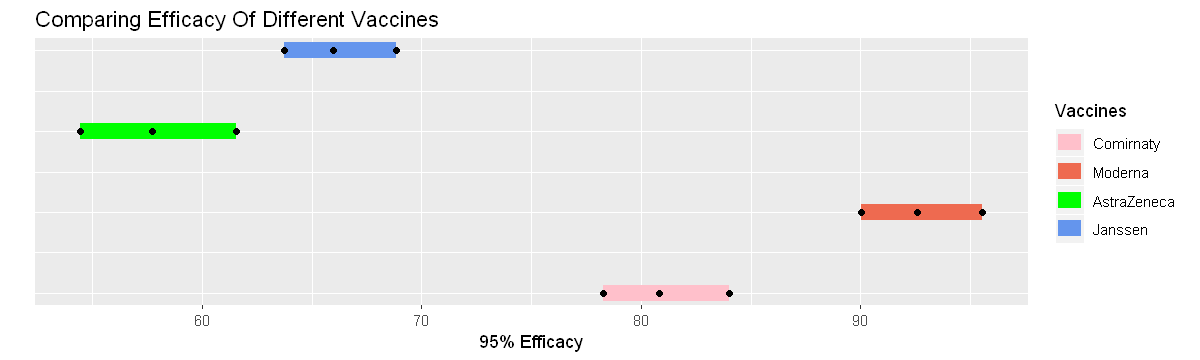

In [22]:
options(repr.plot.width=10, repr.plot.height=3)

d <- ggplot()
p <- d + geom_segment(aes(x=intervals_95_i[1,1], y = 0, xend = intervals_95_i[1,3], yend = 0, color = "Comirnaty"), size = 4.5) +
    geom_point(aes(x=intervals_95_i[1,4],y=0),colour="black") +
    geom_point(aes(x=intervals_95_i[1,1],y=0),colour="black") +
    geom_point(aes(x=intervals_95_i[1,3],y=0),colour="black") +

    geom_segment(aes(x=intervals_95_i[2,1], y = 1, xend = intervals_95_i[2,3], yend = 1, color = "Moderna"),  size = 4.5) +
    geom_point(aes(x=intervals_95_i[2,4],y=1),colour="black") +
    geom_point(aes(x=intervals_95_i[2,1],y=1),colour="black") +
    geom_point(aes(x=intervals_95_i[2,3],y=1),colour="black") +

    geom_segment(aes(x=intervals_95_i[3,1], y = 2, xend = intervals_95_i[3,3], yend = 2, color = "AstraZeneca"), size = 4.5) +
    geom_point(aes(x=intervals_95_i[3,4],y=2),colour="black") +
    geom_point(aes(x=intervals_95_i[3,1],y=2),colour="black") +
    geom_point(aes(x=intervals_95_i[3,3],y=2),colour="black") +

    geom_segment(aes(x=intervals_95_i[4,1], y = 3, xend = intervals_95_i[4,3], yend = 3, color = "Janssen"), size = 4.5) +
    geom_point(aes(x=intervals_95_i[4,4],y=3),colour="black") +
    geom_point(aes(x=intervals_95_i[4,1],y=3),colour="black") +
    geom_point(aes(x=intervals_95_i[4,3],y=3),colour="black") +

    ggtitle("Comparing Efficacy Of Different Vaccines") +
    labs(x = "95% Efficacy", y = "") +
    theme(axis.text.y = element_blank(),
    axis.ticks.y = element_blank()) +
    #legend.position = c(90,3)) +
    scale_color_manual(name='Vaccines',
                     breaks=c('Comirnaty', 'Moderna', 'AstraZeneca', 'Janssen'),
                     values=c('Comirnaty' = "pink", 'Moderna' = "coral2", 'AstraZeneca' = "green", 'Janssen' = "cornflowerblue"))
    
p

The efficacy 95% interval is the highest for the Moderna vaccine, and the lowest for the AstraZeneca vaccine which has roughly 15% less efficacy. The mean and 95% credibility interval points are plotted in black. 

More recently tests on the efficacy of Vaccine for young people have started. Try to collect available official data from the European medicines Agency (https://www.ema.europa.eu/en) or the U.S.
Food and Drug (FDA) (https://www.fda.gov/)

PART 2: perform a bayesian analysis of the data as a function of the age of the patients.

The FDA has only authorised use of the Pfizer-BioNTech (Comirnaty) vaccine to those aged under 18 (and over 12). 


In [ ]:
#i am sorry but i cannot find the data of cases per age of participant 